In [1]:
import numpy as np

from scipy.special import j1, struve

from AcousticProperties import *
from GmshBoundaries import *
from RayleighSolver import *
from SamplingPatterns import *

from Plots import *
%matplotlib inline

import gmsh
from joblib import Parallel, delayed


def magnitude(k, boundary_condition, samples):
    solution = solver.solve_boundary(k, boundary_condition)
    phi = solver.solve_samples(solution, samples)
    return sound_magnitude(sound_pressure(k, phi))

def analytical_pressure(R, V, k, r, theta, rho = 1.205, c = 344.0):
    "From Morse & Ingard: Theoretical Acoustics"
    sin_theta = k * R * np.sin(theta)
    f_omega = 2.0 * V * np.pi * R**2 * (2.0 * j1(sin_theta) / sin_theta)
    return -1j * k * rho * c * np.exp(1j * k * r) / (4 * np.pi * r) * f_omega

def analytical_magnitude(R, V, k, r, theta, rho = 1.205, c = 344.0):
    return sound_magnitude(analytical_pressure(R, V, k, r, theta, rho, c))

def analytical_zm(r, aK, rho, c):
    "From Pierce: Acoustics"
    R1 = 1.0 - 2 * j1(2.0 * aK * r) / (2.0 * aK * r)
    X1 = 2 * struve(1, 2.0 * aK * r) / (2.0 * aK * r)
    Zm = density * c * np.pi * r**2 * (R1 - 1j * X1)
    return Zm

def numerical_zm(k, boundary_condition):
    solution = solver.solve_boundary(k, boundary_condition)
    return solution.mechanical_impedance()


V = 1.0 # piston velocity
c = 344.0
density = 1.205
r = 0.19
max_edge = 0.0235 #0.0475

mesh = disk(r, 0.0, "Woofer15", max_edge) # 15 inch woofer
samples, _, angles = semi_circle(5, 180, "yz")

frequencies = np.array([100, 500, 1000, 5000], dtype=np.float32)

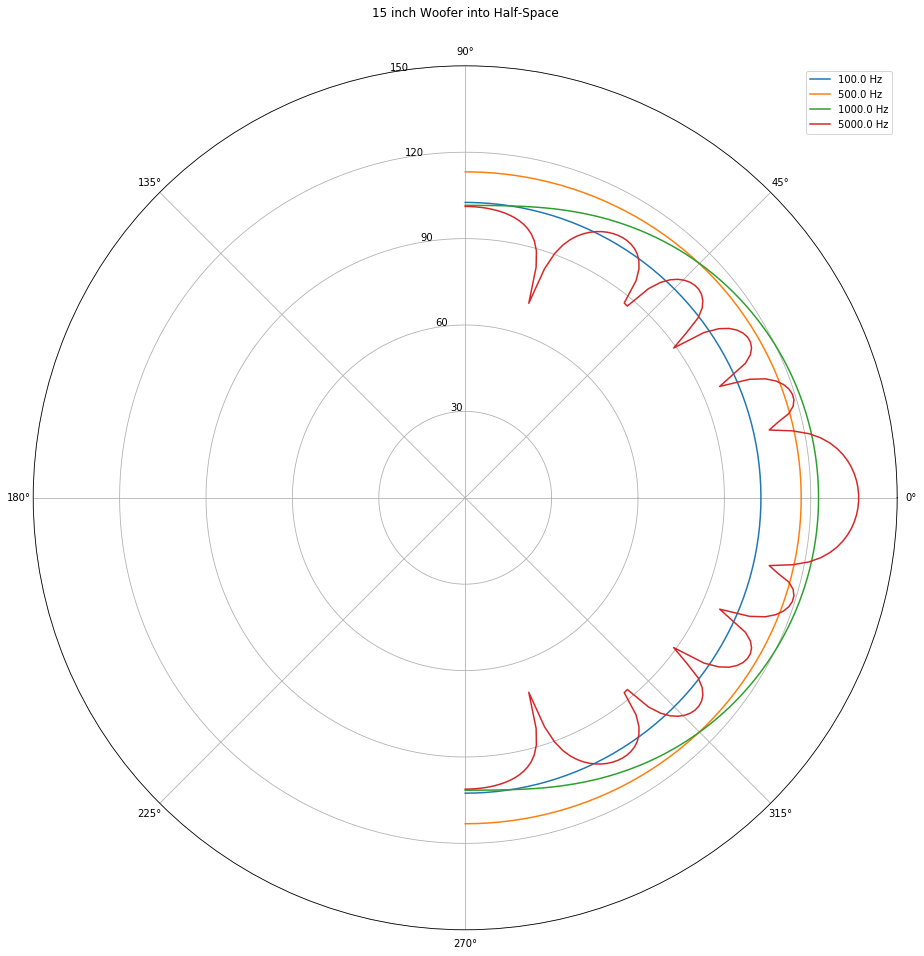

CPU times: user 588 ms, sys: 38.7 ms, total: 627 ms
Wall time: 13.4 s


In [2]:
%%time
solver = RayleighSolver3D(mesh)
boundary_condition = BoundaryCondition(solver.len())
boundary_condition.alpha.fill(0.0)
boundary_condition.beta.fill(1.0)
boundary_condition.f.fill(V)

wavenumbers = frequency_to_wavenumber(frequencies)
magnitudes = Parallel(n_jobs=4)(delayed(magnitude)(k, 
                                                   boundary_condition, 
                                                   samples) for k in wavenumbers)
polar_plot("15 inch Woofer into Half-Space", frequencies, angles, magnitudes)

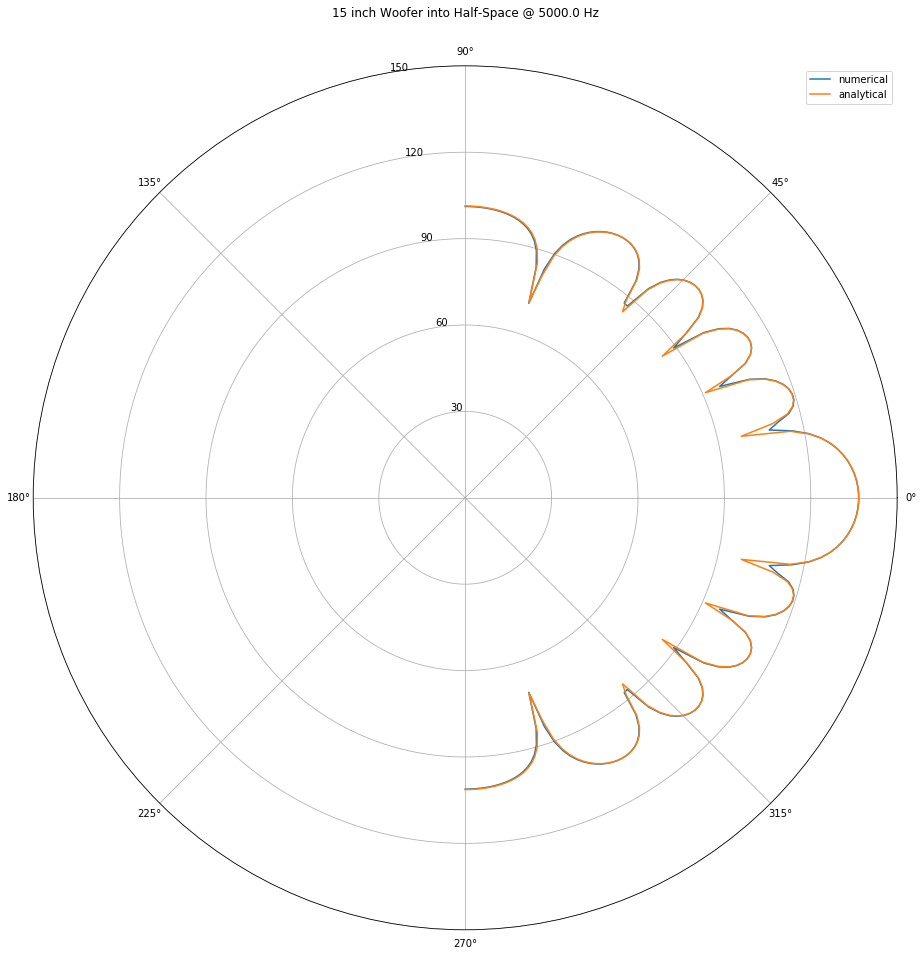

CPU times: user 519 ms, sys: 11.1 ms, total: 530 ms
Wall time: 528 ms


In [3]:
%%time
f = 5000.0
k = frequency_to_wavenumber(f)
analytical_magnitudes = analytical_magnitude(r, V, k, 5.0, angles)

fig = plt.figure(figsize=(15, 15))
ax = fig.add_axes([0.1, 0.1, 0.8, 0.8], projection='polar')
ax.set_title("15 inch Woofer into Half-Space @ " + str(f) + " Hz")
ax.plot(angles, magnitudes[3], label="numerical")
ax.plot(angles, analytical_magnitudes, label="analytical")
ax.legend()
ax.set_rgrids([30, 60, 90, 120, 150], horizontalalignment="left")
ax.set_rlabel_position(100.0)  # get radial labels away from plotted line
ax.grid(True)
plt.show()

CPU times: user 382 ms, sys: 5.32 ms, total: 387 ms
Wall time: 390 ms


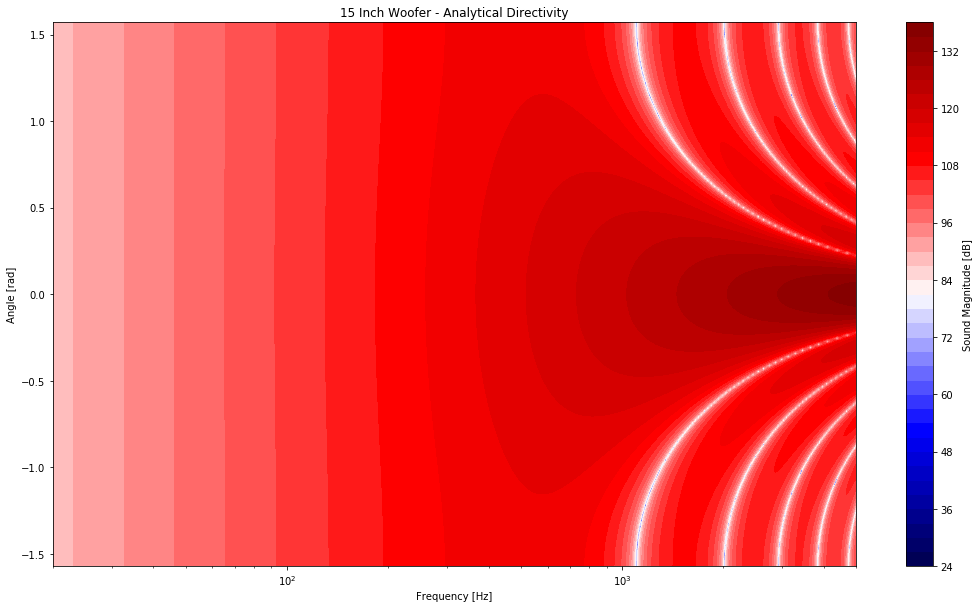

In [8]:
%%time
frequency_samples = 600
frequencies = np.logspace(np.log10(20), np.log10(5000), frequency_samples)
angle_samples = 180
samples, _, angles = semi_circle(5, angle_samples, "yz")
wavenumbers = frequency_to_wavenumber(frequencies)

magnitudes = Parallel(n_jobs=4)(delayed(analytical_magnitude)(r, V, k, 5.0, angles) for k in wavenumbers)
magnitudes = np.asarray(magnitudes).transpose()

plot_polar_map("15 Inch Woofer - Analytical Directivity", 
               frequencies, angles, magnitudes, 3)

CPU times: user 1.49 s, sys: 85.2 ms, total: 1.57 s
Wall time: 29min 51s


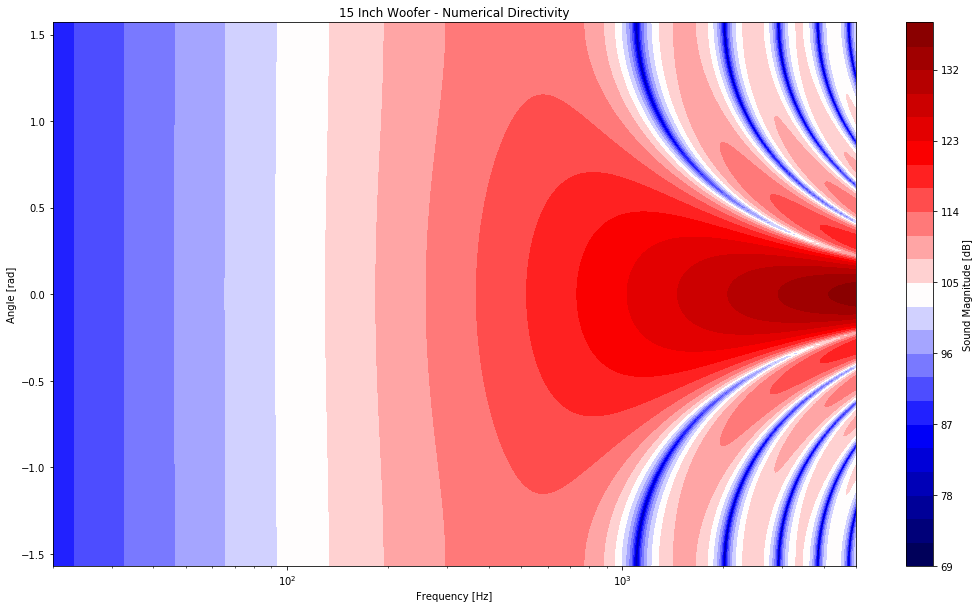

In [5]:
%%time
magnitudes = Parallel(n_jobs=4)(delayed(magnitude)(k, boundary_condition, samples) for k in wavenumbers)
magnitudes = np.asarray(magnitudes).transpose()

plot_polar_map("15 Inch Woofer - Numerical Directivity",
               frequencies, angles, magnitudes, 3)

In [6]:
%%time
analytical_zm = analytical_zm(r, wavenumbers, density, c)

numerical_zm = Parallel(n_jobs=4)(delayed(numerical_zm)(k, boundary_condition) for k in wavenumbers)
numerical_zm = np.asarray(numerical_zm)

CPU times: user 1.33 s, sys: 47.9 ms, total: 1.38 s
Wall time: 24min 5s


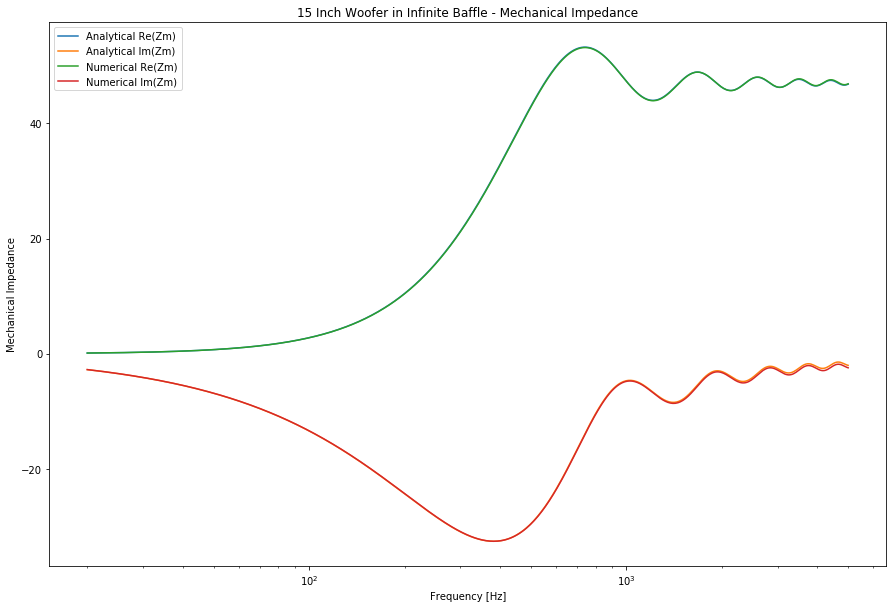

In [7]:
fig, ax = plt.subplots(figsize = (15, 10))
ax.set_title('15 Inch Woofer in Infinite Baffle - Mechanical Impedance')
ax.set_xlabel('Frequency [Hz]')
ax.set_xscale('log') 
ax.set_ylabel('Mechanical Impedance')
ax.plot(frequencies, np.real(analytical_zm), label='Analytical Re(Zm)')
ax.plot(frequencies, np.imag(analytical_zm), label='Analytical Im(Zm)')
ax.plot(frequencies, np.real(numerical_zm), label='Numerical Re(Zm)')
ax.plot(frequencies, np.imag(numerical_zm), label='Numerical Im(Zm)')
ax.legend()